In [1]:
import re
import string
import unicodedata
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
print(string.punctuation)

#pd.options.display.max_rows = None
#pd.options.display.max_columns = 100

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [2]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [3]:
data = pd.read_csv('tweet-sentiment-extraction/sample_submission.csv')
test = pd.read_csv('tweet-sentiment-extraction/test.csv')
train = pd.read_csv('tweet-sentiment-extraction/train.csv',encoding='utf-8-sig')

In [4]:
display(test.head(1))
print(test.shape)
print(test.isnull().sum())
display(train.tail(1))
print(train.shape)
print(train.isnull().sum())

,textID,text,sentiment
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive


(3535, 3)
textID       0
text         0
sentiment    0
dtype: int64


,textID,text,selected_text,sentiment
27485,1c1f3724db,"ha ha, and what game is that? i like games",? i like,positive


(27486, 4)
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [5]:
train = train.dropna().reset_index(drop = True)
print(train.shape)
print(train.isnull().sum())
display(train.tail(1))

(27485, 4)
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


,textID,text,selected_text,sentiment
27484,1c1f3724db,"ha ha, and what game is that? i like games",? i like,positive


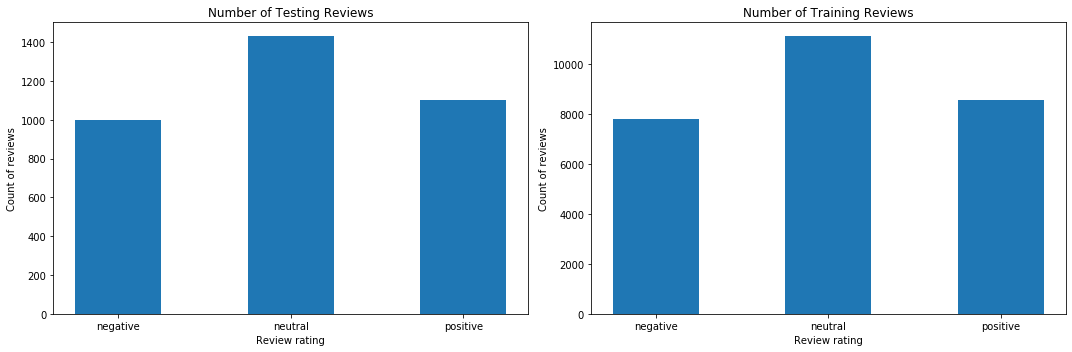

In [6]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

test_values, test_counts = np.unique(test['sentiment'], return_counts = True)
ax[0].bar(test_values, test_counts, width = 0.5)
ax[0].set_xlabel('Review rating')
ax[0].set_ylabel('Count of reviews')
ax[0].set_title('Number of Testing Reviews')


train_values, train_counts = np.unique(train['sentiment'], return_counts = True)
ax[1].bar(train_values, train_counts, width = 0.5)
ax[1].set_xlabel('Review rating')
ax[1].set_ylabel('Count of reviews')
ax[1].set_title('Number of Training Reviews')

plt.tight_layout()

In [7]:
train['sentiment'] = train['sentiment'].map({"negative":0, "neutral":1, 'positive':2})
train.head(5)

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,2


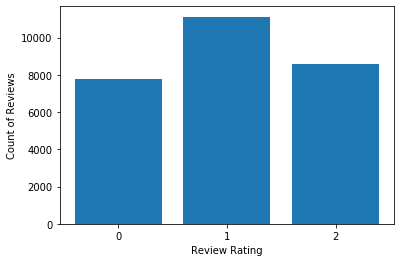

In [8]:
values, counts = np.unique(train['sentiment'], return_counts=True)
plt.figure()
plt.bar(["0","1",'2'], counts)
plt.xlabel('Review Rating')
plt.ylabel('Count of Reviews')
plt.show()

In [9]:
print(counts/np.sum(counts))

[0.28328179 0.40447517 0.31224304]


In [10]:
train

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,2
...,...,...,...,...
27480,3dbae74fcd,"I want to go to VP, but no one is willing to c...","I want to go to VP, but no one is willing to c...",1
27481,63147b35cb,"Wah, why are you sad?","Wah, why are you sad?",1
27482,bdb196a09f,playing sudoku while mommy makes me breakfast ...,playing sudoku while mommy makes me breakfast ...,1
27483,18c2a1e98e,see u bye see u! i love the hot30,i love,2


# EDA

In [11]:
train['clean_text'] = train['text']

In [12]:
train.head()

,textID,text,selected_text,sentiment,clean_text
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1,Spent the entire morning in a meeting w/ a ven...
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2,Oh! Good idea about putting them on ice cream
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1,says good (or should i say bad?) afternoon! h...
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0,i dont think you can vote anymore! i tried
4,bf7473b12d,haha better drunken tweeting you mean?,better,2,haha better drunken tweeting you mean?


#### Word Counts & Characters Counts

In [13]:
train['word_counts'] = train['text'].apply(lambda x : len(str(x).split()))
train['char_counts'] = train['text'].apply(lambda x : len(x))

#### Average Word Length

In [14]:
def avg_length(x):
    words = x.split()
    word_len = 0
    for word in words:
        word_len = word_len + len(word)
    return word_len/len(words)

In [15]:
train['avg_counts'] = train['text'].apply(lambda x : avg_length(x))

#### Count #Hash Tags and @Mentions 

In [16]:
train['hashtags'] = train['text'].apply(lambda x: [w for w in x.split() if w.startswith('#')])
train['mentions'] = train['text'].apply(lambda x: [w for w in x.split() if w.startswith('@')])
train['hashtags_counts'] = train['hashtags'].apply(lambda x: len(x))
train['mentions_counts'] = train['mentions'].apply(lambda x: len(x))

#### Count and Remove URL

In [17]:
train['url'] = train['text'].apply(lambda x: re.findall(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', x))
train['url_counts'] = train['url'].apply(lambda x: len(x))
train['clean_text'] = train['clean_text'].apply(lambda x: re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", x))

#### Remove Accented Characters

In [18]:
def accent_char(x):
    x = unicodedata.normalize('NFKD',x).encode('ascii','ignore').decode('utf-8','ignore')
    return x

In [19]:
train['clean_text'] = train['clean_text'].apply( lambda x: accent_char(x))

#### Convert to Lower Case

In [20]:
train['clean_text'] = train['clean_text'].apply( lambda x: x.lower())

#### Remove Punctuation , Numbers & Multiple Spaces

In [21]:
train['clean_text'] = train['clean_text'].apply( lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x))
train['clean_text'] = train['clean_text'].apply( lambda x: re.sub(r'\d', '', x))
train['clean_text'] = train['clean_text'].apply( lambda x: " ".join(x.split()))

#### Lemmatization

In [22]:
def lemmatization(x):
    texts = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        if lemma == '-PRON-':
            lemma = token.text
        texts.append(lemma)
    return(" ".join(texts))

In [23]:
train['clean_text'] = train['clean_text'].apply( lambda x: lemmatization(x))

#### Remove Stop Words & Character less than 1

In [24]:
train['clean_text'] = train['clean_text'].apply( lambda x: " ".join([w for w in x.split() if w not in stop_words]))
train['clean_text'] = train['clean_text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>1]))

# Top 10 Words & WordCloud

In [25]:
neg_text = [text for text in train[train['sentiment'] == 0]['clean_text']]
neg_text = ' '.join(neg_text).split()

net_text = [text for text in train[train['sentiment'] == 1]['clean_text']]
net_text = ' '.join(net_text).split()

pos_text = [text for text in train[train['sentiment'] == 2]['clean_text']]
pos_text = ' '.join(pos_text).split()

train_text = [text for text in train['clean_text']]
train_text = ' '.join(train_text).split()

### Negative Text

In [26]:
count_neg = Counter(neg_text)
top_neg = count_neg.most_common(20)
pd.DataFrame(top_neg);

In [27]:
neg_words = [word[0] for word in top_neg]
neg_counts = [word[1] for word in top_neg]
neg_reshape = ' '.join([word[0] for word in  count_neg.most_common(200)])
neg_wordcloud = WordCloud( width=800, height=800,
                      random_state=50, max_font_size=200).generate(neg_reshape)

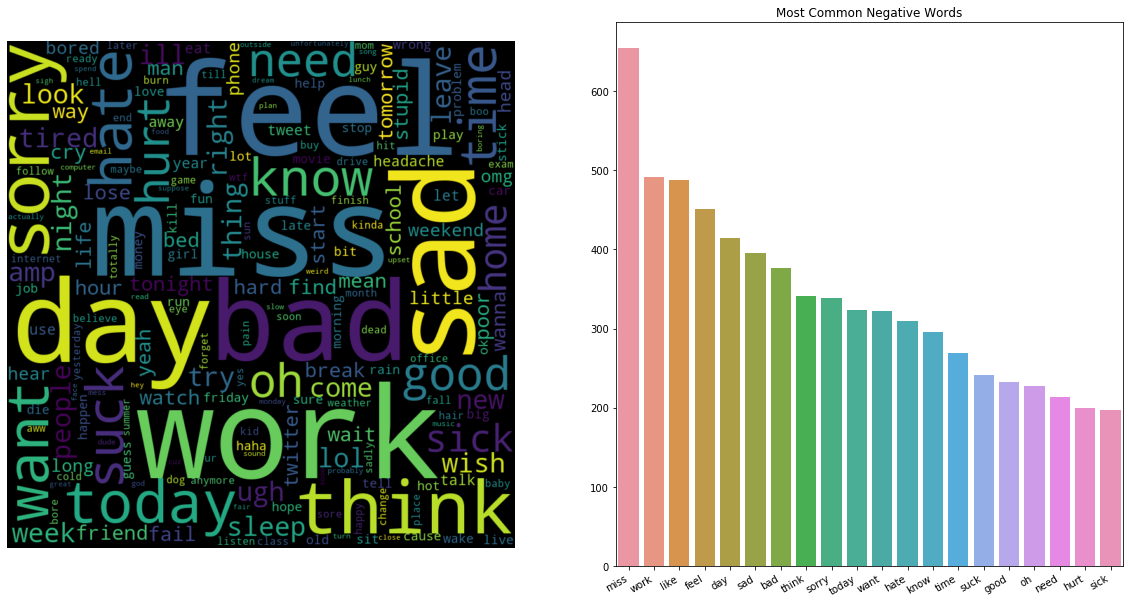

In [28]:
fig, ax = plt.subplots(1,2,figsize= (20,10))

ax[0].imshow(neg_wordcloud, interpolation="bilinear")
ax[0].axis('off')

ax[1] = sns.barplot(x=neg_words, y=neg_counts)
ax[1].set_title('Most Common Negative Words')
plt.xticks(rotation=30, ha='right')


plt.show()

### Positive Text

In [29]:
count_pos = Counter(pos_text)
top_pos = count_pos.most_common(20)
pd.DataFrame(top_pos);

In [30]:
pos_words = [word[0] for word in top_pos]
pos_counts = [word[1] for word in top_pos]

pos_reshape = ' '.join([word[0] for word in  count_pos.most_common(200)])

pos_wordcloud = WordCloud( width=800, height=800,
                      random_state=50, max_font_size=200).generate(pos_reshape)

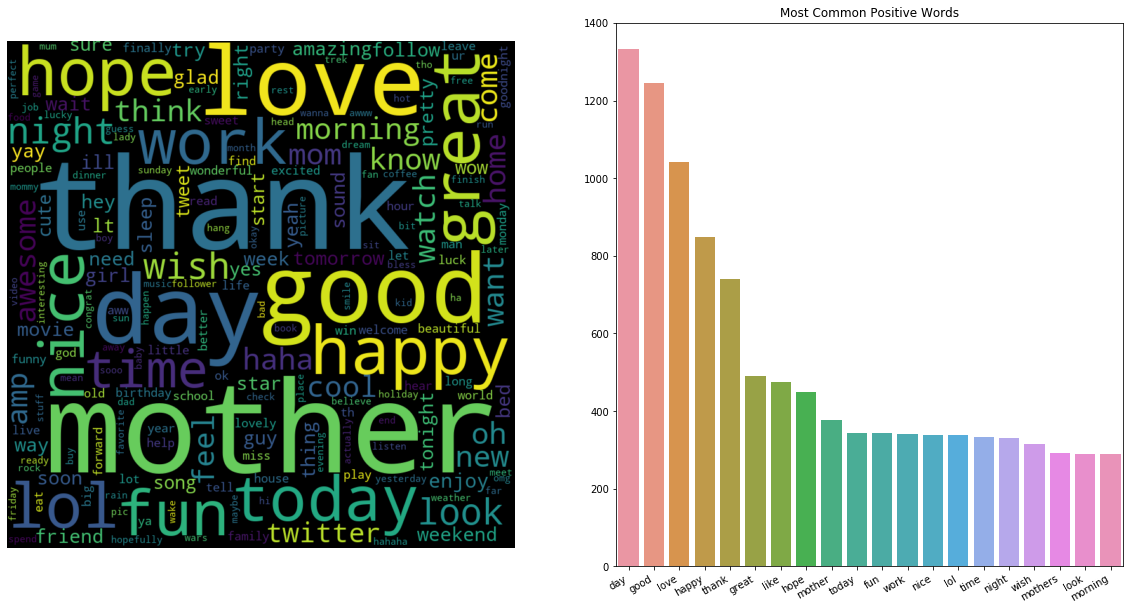

In [31]:
fig, ax = plt.subplots(1,2,figsize= (20,10))

ax[0].imshow(pos_wordcloud, interpolation="bilinear")
ax[0].axis('off')


ax[1] = sns.barplot(x=pos_words, y=pos_counts)
ax[1].set_title('Most Common Positive Words')
plt.xticks(rotation=30, ha='right')


plt.show()

### Netural Text

In [32]:
count_net = Counter(net_text)
top_net = count_net.most_common(20)
net_words = [word[0] for word in top_net]
net_counts = [word[1] for word in top_net]
net_reshape = ' '.join([word[0] for word in  count_net.most_common(200)])
pd.DataFrame(top_net);

In [33]:

net_wordcloud = WordCloud( width=800, height=800,
                      random_state=50, max_font_size=200).generate(net_reshape)

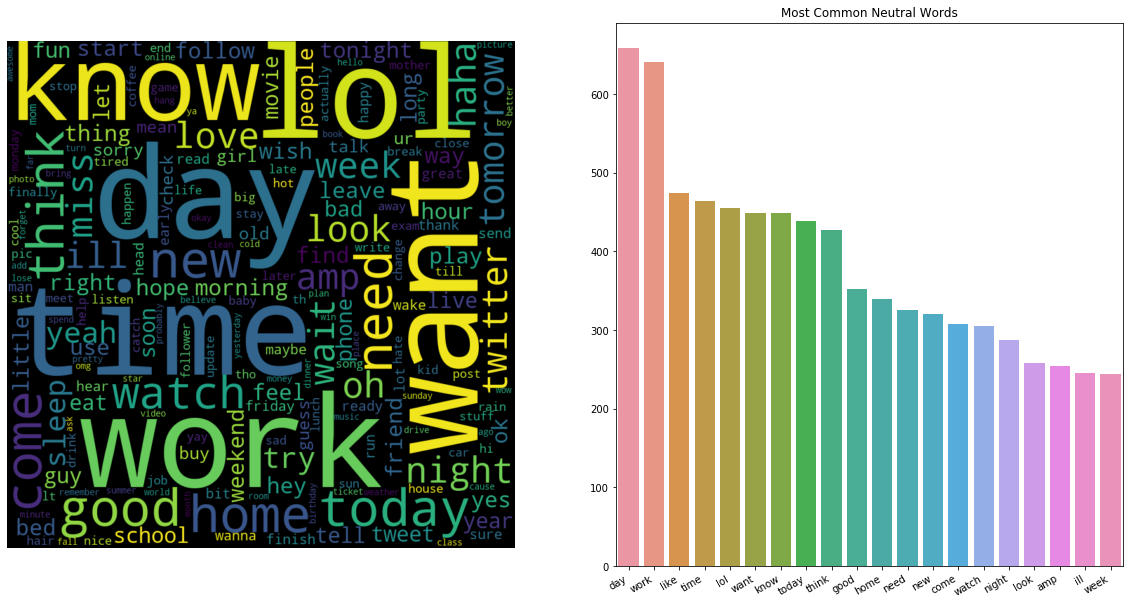

In [34]:
fig, ax = plt.subplots(1,2,figsize= (20,10))

ax[0].imshow(net_wordcloud, interpolation="bilinear")
ax[0].axis('off')

ax[1] = sns.barplot(x=net_words, y=net_counts)
ax[1].set_title('Most Common Neutral Words')
plt.xticks(rotation=30, ha='right')

plt.show()

# TF - IDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 0.0003).fit(train["clean_text"])
X_train = tfidf.transform(train["clean_text"])
my_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=X_train.toarray())

In [36]:
my_df.head(5)

,able,absolutely,abt,ac,accept,access,accident,accidentally,accord,account,...,young,youquot,youtube,yr,yrs,yum,yummy,yup,zero,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
sentiment = pd.DataFrame(train['sentiment'])
df = my_df.join(sentiment)

In [38]:
df

,able,absolutely,abt,ac,accept,access,accident,accidentally,accord,account,...,youquot,youtube,yr,yrs,yum,yummy,yup,zero,zombie,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
27481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
27482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
27483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


# Modelling

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV

In [40]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [41]:
my_random_forest = RandomForestClassifier(n_estimators=50)
my_random_forest.fit(X_train, y_train)
my_random_forest.score(X_test,y_test)

0.6923356779044385

In [42]:
logreg = LogisticRegression(solver = 'lbfgs',multi_class='auto')
logreg.fit(X_train, y_train)
logreg.score(X_test,y_test)

/Users/austinyu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.6850594227504244

In [43]:
DT_model = DecisionTreeClassifier().fit(X_train, y_train)
DT_model.score(X_train,y_train)
DT_model.score(X_test,y_test)

0.6491632306572884

In [44]:
sgd = linear_model.SGDClassifier().fit(X_train, y_train)
sgd.score(X_train,y_train)
sgd.score(X_test,y_test)

0.6964588891583798

In [45]:
svm = LinearSVC().fit(X_train, y_train)
svm.score(X_train,y_train)
svm.score(X_test,y_test)

0.6805723987387824

In [46]:
lgrcv = LogisticRegressionCV(cv = 2, random_state=42, max_iter=100).fit(X_train, y_train)
lgrcv.score(X_train,y_train)
lgrcv.score(X_test,y_test)

/Users/austinyu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/austinyu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/austinyu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/austinyu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/austinyu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:94

0.6873635702158623